<a href="https://colab.research.google.com/github/pxpc2/qualvinho/blob/main/decisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
! [ -e /content ] && pip install -Uqq fastbook
!pip install -q dtreeviz
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.collab import *
from fastai.tabular.all import *
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import dtreeviz

In [74]:
wines = pd.read_csv('/content/gdrive/MyDrive/XWines_Slim/XWines_Slim_1K_wines.csv',
                    usecols=['WineID', 'WineName', 'Type', 'Grapes',
                             'Body', 'Harmonize', 'Acidity', 'ABV', 'Code', 'Country', 'Elaborate', 'WineryName'],
                     delimiter=',', header=None, skiprows=1, low_memory=False,
                    names=['WineID', 'WineName', 'Type', 'Elaborate', 'Grapes',
                           'Harmonize', 'ABV', 'Body', 'Acidity', 'Code',
                           'Country', 'RegionID', 'RegionName', 'WineryID',
                           'WineryName','Website', 'Vintages'],
                    dtype={'WineID': int, 'WineName': str, 'Type': str,
                           'Grapes': str, 'Harmonize': str, 'Body': str,
                           'Acidity': str, 'ABV': str,
                           'Code': str, 'Elaborate': str, 'Country': str, 'WineryName': str})



ratings = pd.read_csv('/content/gdrive/MyDrive/XWines_Slim/XWines_Slim_150K_ratings.csv',
                      usecols=['UserID', 'WineID', 'Rating'],
                      delimiter=',', header=None, skiprows=1, low_memory=False,
                      names=['RatingID', 'UserID', 'WineID', 'Vintage', 'Rating', 'Date'],
                      dtype={'UserID': int, 'WineID': int, 'Rating': float})

In [75]:
df = ratings.merge(wines)
df.columns

Index(['UserID', 'WineID', 'Rating', 'WineName', 'Type', 'Elaborate', 'Grapes',
       'Harmonize', 'ABV', 'Body', 'Acidity', 'Code', 'Country', 'WineryName'],
      dtype='object')

In [76]:
df['Acidity'].unique()

array(['High', 'Medium', 'Low'], dtype=object)

In [77]:
df['Rating'].unique()

array([4.5, 4. , 3.5, 5. , 3. , 1. , 2. , 2.5, 1.5])

In [78]:
bodies = 'Very full-bodied', 'Full-bodied', 'Medium-bodied', 'Light-bodied', 'Very light-bodied'
df['Body'] = df['Body'].astype('category')
df['Body'].cat.set_categories(bodies, ordered=True, inplace=True)

<ipython-input-78-29c373dca47b>:3: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.


In [79]:
acidities = 'High', 'Medium', 'Low'
df['Acidity'] = df['Acidity'].astype('category')
df['Acidity'].cat.set_categories(acidities, ordered=True, inplace=True)

<ipython-input-79-054233d5dd41>:3: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.


In [80]:
dep_var = 'Rating'
df[dep_var] = np.log(df[dep_var])

In [81]:
procs = [Categorify, FillMissing]

In [82]:
splits = RandomSplitter(seed=42)(df)

In [83]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [84]:
len(to.train),len(to.valid)

(120000, 30000)

In [85]:
to.show(3)

,WineName,Type,Elaborate,Grapes,Harmonize,ABV,Body,Acidity,Code,Country,WineryName,UserID,WineID,Rating
137355,Unwooded Pinot Noir,Red,Varietal/100%,['Pinot Noir'],"['Beef', 'Veal', 'Game Meat', 'Poultry']",12.5,Medium-bodied,High,ZA,South Africa,Haute Cabrière,1149843,171438,1.252763
35229,Hemisferio Reserva Carmenère,Red,Varietal/100%,['Carmenère'],"['Beef', 'Pasta', 'Lamb', 'Poultry']",13.0,Full-bodied,High,CL,Chile,Miguel Torres Chile,1200644,162756,0.916291
96428,Malbec,Red,Varietal/100%,['Malbec'],"['Beef', 'Lamb', 'Poultry']",13.9,Very full-bodied,High,AR,Argentina,La Linda,1284340,167425,1.098612


In [86]:
to.items.head(3)

,UserID,WineID,Rating,WineName,Type,Elaborate,Grapes,Harmonize,ABV,Body,Acidity,Code,Country,WineryName
137355,1149843,171438,1.252763,751,3,12,194,80,15,3,1,31,24,372
35229,1200644,162756,0.916291,348,3,12,60,63,20,2,1,7,6,511
96428,1284340,167425,1.098612,423,3,12,134,43,29,1,1,1,1,434


In [87]:
to.classes['Body']

['#na#', 'Very full-bodied', 'Full-bodied', 'Medium-bodied', 'Light-bodied', 'Very light-bodied']

In [88]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [89]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

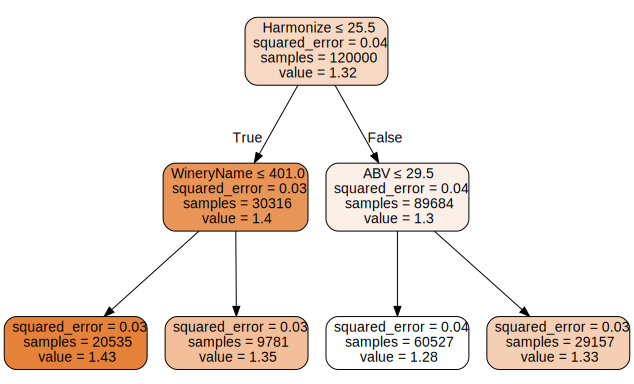

In [90]:
draw_tree(m, xs, size=25, leaves_parallel=True, precision=2)

In [91]:
samp_idx = np.random.permutation(len(y))[:500]

viz_rmodel = dtreeviz.model(model=m,
                            X_train=xs.iloc[samp_idx],
                            y_train=y.iloc[samp_idx],
                            feature_names=xs.columns,
                            target_name=dep_var)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


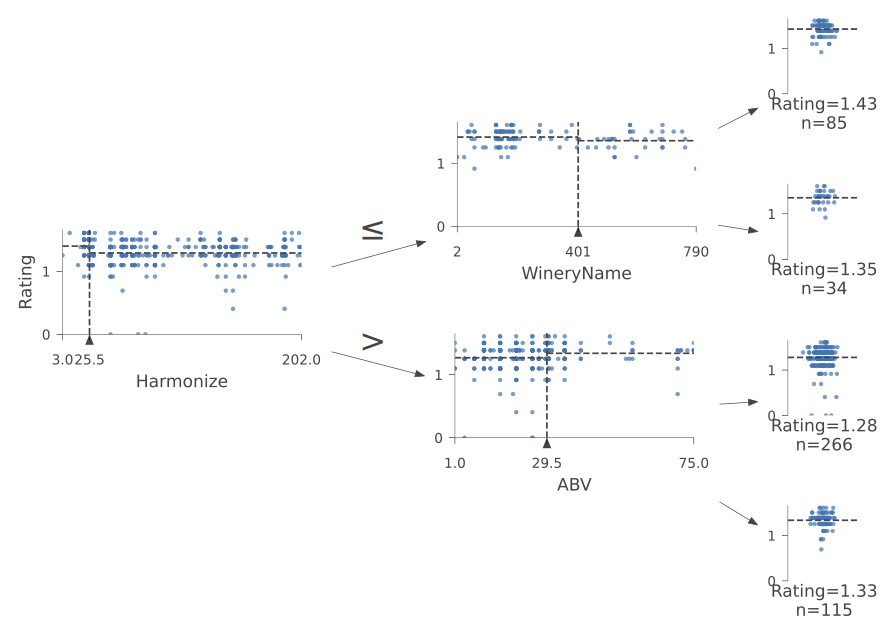

In [92]:
viz_rmodel.view(orientation="LR", fontname="DejaVu Sans", scale=2.3, label_fontsize=10)

In [93]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [94]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)
m_rmse(m, xs, y)

0.0

In [95]:
m_rmse(m, valid_xs, valid_y)

0.224689

In [96]:
m.get_n_leaves(), len(xs)

(78145, 120000)

In [97]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.152785, 0.163848)

In [98]:
m.get_n_leaves()

3690

In [99]:
def rf(xs, y, n_estimators=50, max_samples=120000,
  max_features=0.5, min_samples_leaf=5, **kwargs):
  return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
          max_samples=max_samples, max_features=max_features,
          min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)
m = rf(xs, y);

In [100]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.139325, 0.164207)

In [101]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.139325, 0.164207)

In [102]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.139325, 0.164207)

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [104]:
r_mse(preds.mean(0), valid_y)

0.164207

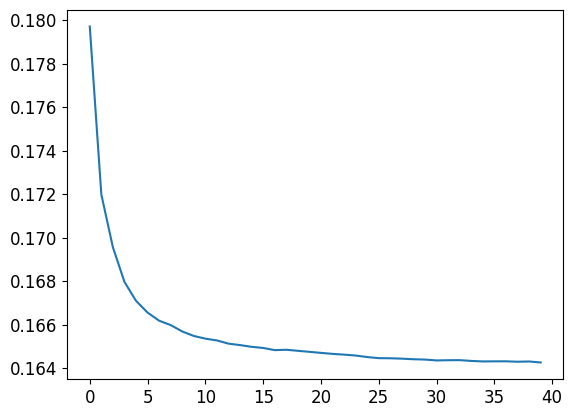

In [105]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

In [106]:
r_mse(m.oob_prediction_, y)

0.16572

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
preds.shape

In [109]:
preds_std = preds.std(0)
preds_std[:5]

array([0.05734269, 0.07960037, 0.04988817, 0.07440126, 0.04411675])

In [111]:
def rf_feat_importance(m, df):
  return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                      ).sort_values('imp', ascending=False)

In [112]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
11,UserID,0.363808
4,Harmonize,0.131074
5,ABV,0.098359
12,WineID,0.095534
10,WineryName,0.086841
0,WineName,0.067209
3,Grapes,0.053250
9,Country,0.025490
8,Code,0.025084
1,Type,0.017299


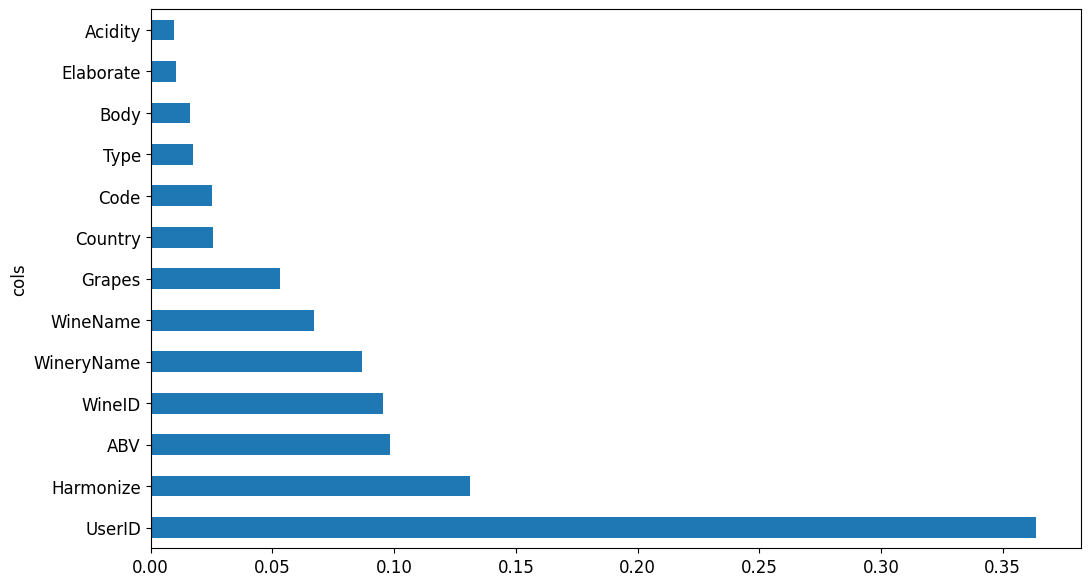

In [114]:
def plot_fi(fi):
  return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

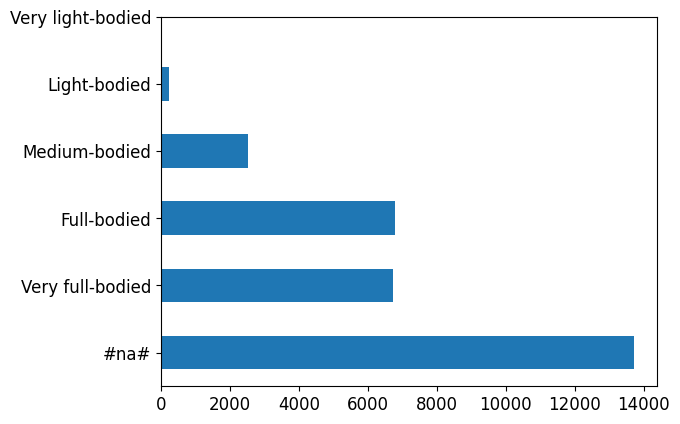

In [120]:
p = valid_xs['Body'].value_counts(sort=False).plot.barh()
c = to.classes['Body']
plt.yticks(range(len(c)), c);

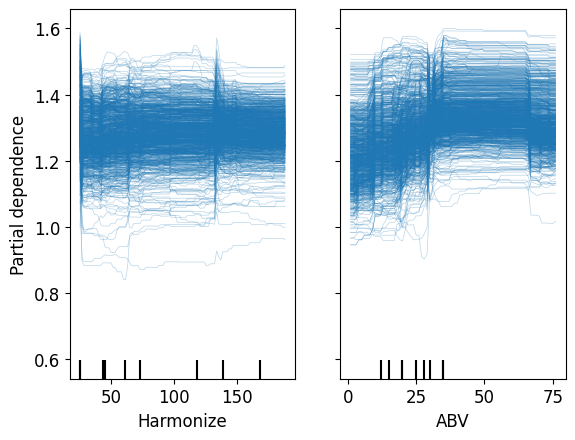

In [124]:
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(m, valid_xs, ['Harmonize','ABV'],
    kind='individual')

Acho que a ideia agora seria fazer a mesma análise mas pra cada Userid um por um, e limpando melhor os dados de harmonizações e ABV. Aí sim dá pra avaliar melhor as relações feitas INDIVIDUALMENTE por cada usuário e entender os dados melhor, pra finalmente formular as perguntas e seus pesos referentes a cada dado